# Random Forest

This is the main notebook covering our try with random forests. Originally, this was our main choice for our non-linear model, but as we saw that XGB performs better with the same amount of tuning, we decided to take that further. This one uses our engineered centrality and subtree-balance features in addition to the centralites, no prediction on the test set here as it was not the main goal. We also look at feature importances with this approach.

- **One-language demo** (Finnish) with hold-out splitting by sentence  
- **Custom root-score** metric (pick max-prob node per sentence), same as in the main XGB model  
- **OOB tuning** (no cross-validation) to speed up hyperparameter search (as seen in class) 
- **Feature importance** analysis per language and across all 21 languages  

Here we can clearly see that our features that we added do not add much to the model.

In [4]:
import pandas as pd
import numpy as np
from time import time
from datetime import timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from itertools import product
from tqdm import tqdm

We try the workflow on Finnish data first:

In [5]:
df = pd.read_csv('../../data/expanded_with_features_non-linear.csv')
df = df[df.language == 'Finnish'].reset_index(drop=True)
df.head(5)

,language,sentence,vertex,vertex.1,n,degree,closeness,harmonic,betweeness,load,...,information,current_flow_betweeness,percolation,second_order,laplacian,is_leaf,pos_norm,max_branch_size,subtree_entropy,is_root
0,Finnish,2,10,24,12,0.272727,0.354839,5.566667,0.472727,0.472727,...,0.032258,0.472727,0.472727,28.248894,0.314286,0,0.833333,23,0.058842,1
1,Finnish,2,1,21,12,0.181818,0.407407,5.500000,0.509091,0.509091,...,0.037037,0.509091,0.509091,22.583180,0.257143,0,0.083333,23,0.058842,0
2,Finnish,2,7,12,12,0.272727,0.440000,6.083333,0.636364,0.636364,...,0.040000,0.636364,0.636364,19.131126,0.342857,0,0.583333,19,0.697646,0
3,Finnish,2,12,13,12,0.090909,0.314286,4.200000,0.000000,0.000000,...,0.028571,0.000000,0.000000,32.954514,0.114286,1,1.000000,20,0.792316,0
4,Finnish,2,9,8,12,0.181818,0.314286,4.816667,0.181818,0.181818,...,0.028571,0.181818,0.181818,32.954514,0.200000,0,0.750000,23,0.058842,0


In [6]:
# Hold-out split by sentence (20% of sentences)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, hold_idx = next(gss.split(df, df.is_root, groups=df.sentence))
train_df = df.iloc[train_idx].reset_index(drop=True)
hold_df  = df.iloc[hold_idx].reset_index(drop=True)

In [7]:
FEATURES = [
  'degree','closeness','harmonic','betweeness','load','pagerank',
  'eigenvector','katz','information','current_flow_betweeness',
  'percolation','second_order','laplacian',
  'is_leaf','pos_norm','max_branch_size','subtree_entropy'
]
X_train, y_train, sent_train = (
    train_df[FEATURES].values,
    train_df.is_root.values,
    train_df.sentence.values
)
X_hold, y_hold, sent_hold = (
    hold_df[FEATURES].values,
    hold_df.is_root.values,
    hold_df.sentence.values
)

In [8]:
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_hold_s  = scaler.transform(X_hold)

In [9]:
# Again, here we evaluate by picking the highest probability node in each sentence
def root_score(sent_ids, y_true, probs):
    dfp = pd.DataFrame({'sent': sent_ids, 'y': y_true, 'p': probs})
    picks = dfp.loc[dfp.groupby('sent')['p'].idxmax()]
    return (picks.y == 1).mean()

In [10]:
param_grid = {
    'n_estimators':     [100, 200, 500],
    'max_depth':        [5, 10, 20, None],
    'min_samples_leaf': [5, 10, 20],
    'max_features':     ['sqrt', 'log2', 0.5],
    'class_weight':     ['balanced_subsample']
}

In [11]:
best_oob = -1.0
best_params = None

In [9]:
start = time()
for ne in param_grid['n_estimators']:
    for md in param_grid['max_depth']:
        for msl in param_grid['min_samples_leaf']:
            for mf in param_grid['max_features']:
                rf = RandomForestClassifier(
                    n_estimators=ne,
                    max_depth=md,
                    min_samples_leaf=msl,
                    max_features=mf,
                    class_weight='balanced_subsample',
                    oob_score=True,
                    random_state=42,
                    n_jobs=-1
                )
                rf.fit(X_train_s, y_train)
                # get per-sample OOB probability for class=1
                oob_probs = rf.oob_decision_function_[:,1]
                oob_root  = root_score(sent_train, y_train, oob_probs)
                print(f"OOB root‐score={oob_root:.3f} | ",
                      f"ne={ne}, md={md}, leaf={msl}, mf={mf}")
                if oob_root > best_oob:
                    best_oob = oob_root
                    best_params = dict(
                        n_estimators=ne, max_depth=md,
                        min_samples_leaf=msl, max_features=mf
                    )
print(f"\nTuning done in {timedelta(seconds=time()-start)}")
print("Best OOB root‐score:", best_oob)
print("Best RF params:", best_params)

OOB root‐score=0.312 |  ne=100, md=5, leaf=5, mf=sqrt
OOB root‐score=0.312 |  ne=100, md=5, leaf=5, mf=log2
OOB root‐score=0.305 |  ne=100, md=5, leaf=5, mf=0.5
OOB root‐score=0.310 |  ne=100, md=5, leaf=10, mf=sqrt
OOB root‐score=0.310 |  ne=100, md=5, leaf=10, mf=log2
OOB root‐score=0.315 |  ne=100, md=5, leaf=10, mf=0.5
OOB root‐score=0.315 |  ne=100, md=5, leaf=20, mf=sqrt
OOB root‐score=0.315 |  ne=100, md=5, leaf=20, mf=log2
OOB root‐score=0.312 |  ne=100, md=5, leaf=20, mf=0.5
OOB root‐score=0.292 |  ne=100, md=10, leaf=5, mf=sqrt
OOB root‐score=0.292 |  ne=100, md=10, leaf=5, mf=log2
OOB root‐score=0.285 |  ne=100, md=10, leaf=5, mf=0.5
OOB root‐score=0.290 |  ne=100, md=10, leaf=10, mf=sqrt
OOB root‐score=0.290 |  ne=100, md=10, leaf=10, mf=log2
OOB root‐score=0.290 |  ne=100, md=10, leaf=10, mf=0.5
OOB root‐score=0.300 |  ne=100, md=10, leaf=20, mf=sqrt
OOB root‐score=0.300 |  ne=100, md=10, leaf=20, mf=log2
OOB root‐score=0.305 |  ne=100, md=10, leaf=20, mf=0.5
OOB root‐scor

In [10]:
# Refit on ALL training data with those best params
rf_final = RandomForestClassifier(
    **best_params,
    class_weight='balanced_subsample',
    oob_score=True,
    random_state=42,
    n_jobs=-1
)
rf_final.fit(X_train_s, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                       min_samples_leaf=10, n_estimators=200, n_jobs=-1,
                       oob_score=True, random_state=42)

In [11]:
# Final OOB & hold‐out
final_oob = root_score(sent_train, y_train, rf_final.oob_decision_function_[:,1])
hold     = root_score(sent_hold,  y_hold,  rf_final.predict_proba(X_hold_s)[:,1])
print(f"Final OOB root‐score on TRAIN:      {final_oob:.3f}")
print(f"Hold‐out root‐score on HELD‐OUT:     {hold:.3f}")

Final OOB root‐score on TRAIN:      0.320
Hold‐out root‐score on HELD‐OUT:     0.370


We can already see here that our engineered features give limited separation of root vs non-root.

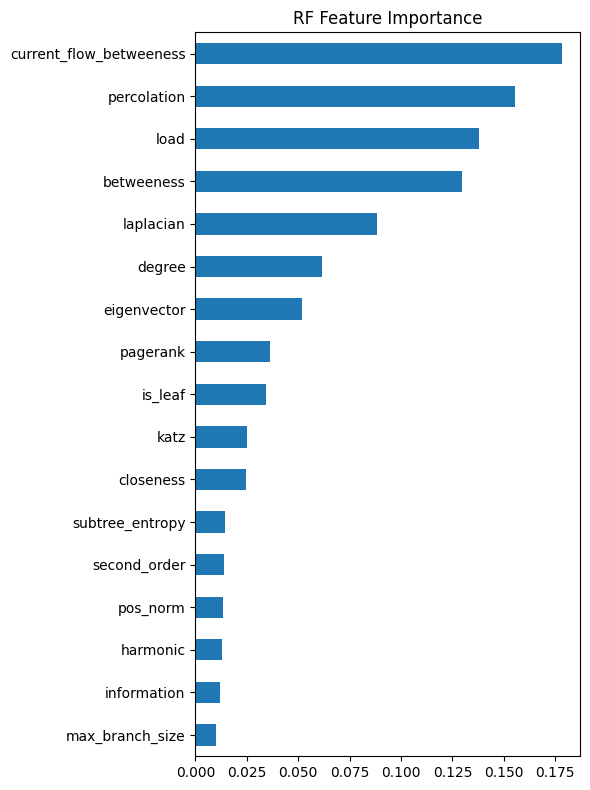

In [12]:
# Feature importances
importances = pd.Series(rf_final.feature_importances_, index=FEATURES)
importances.sort_values().plot.barh(figsize=(6,8), title="RF Feature Importance")
plt.tight_layout()
plt.show()

**Extending to all languages:** Here we repeat the OOB tuning per language and collect feature importances

In [14]:
df = pd.read_csv('../../data/expanded_with_features_non-linear.csv')
param_grid = {
    'n_estimators':     [100, 200, 300],
    'max_depth':        [5, 10, 20, None],
    'min_samples_leaf': [5, 10, 20],
    'max_features':     ['sqrt','log2',0.5],
}

In [15]:
records = []
imp_mat = pd.DataFrame(index=sorted(df.language.unique()), columns=FEATURES, dtype=float)

In [16]:
records = []
for lang in tqdm(sorted(df.language.unique()), desc="Languages"):
    sub = df[df.language == lang].reset_index(drop=True)
    # scale per-language
    scaler = StandardScaler().fit(sub[FEATURES])
    Xs = scaler.transform(sub[FEATURES])
    y  = sub.is_root.values
    s  = sub.sentence.values

    # OOB‐tuning
    best_score, best_params, best_rf = -1.0, None, None
    for ne, md, msl, mf in product(
        param_grid['n_estimators'],
        param_grid['max_depth'],
        param_grid['min_samples_leaf'],
        param_grid['max_features'],
    ):
        rf = RandomForestClassifier(
            n_estimators=ne,
            max_depth=md,
            min_samples_leaf=msl,
            max_features=mf,
            class_weight='balanced_subsample',
            oob_score=True,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(Xs, y)
        oob_p = rf.oob_decision_function_[:,1]
        oob_sc = root_score(s, y, oob_p)
        if oob_sc > best_score:
            best_score, best_params, best_rf = oob_sc, dict(
                n_estimators=ne, max_depth=md,
                min_samples_leaf=msl, max_features=mf
            ), rf

    # hold‐out split by sentence to get an explicit val score
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, val_idx = next(gss.split(sub, sub.is_root, groups=sub.sentence))
    val = sub.iloc[val_idx]
    X_val_s = scaler.transform(val[FEATURES])
    probs   = best_rf.predict_proba(X_val_s)[:,1]
    val_sc  = root_score(val.sentence.values, val.is_root.values, probs)

    # both val and OOB
    records.append({
        'language':         lang,
        'best_oob_root_sc': best_score,
        'val_root_sc':      val_sc,
        **{f'param_{k}': v for k,v in best_params.items()}
    })

tuning_df = pd.DataFrame(records).set_index('language')

Languages: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [40:55<00:00, 116.93s/it]


In [17]:
# summarise hyper‐tuning results
tuning_df = pd.DataFrame(records).set_index('language')
display(tuning_df)

,best_oob_root_sc,val_root_sc,param_n_estimators,param_max_depth,param_min_samples_leaf,param_max_features
language,,,,,,
Arabic,0.298,0.37,100,5,10,sqrt
Chinese,0.260,0.30,100,5,10,sqrt
Czech,0.298,0.67,100,20,10,sqrt
English,0.278,0.60,200,10,10,0.5
Finnish,0.334,0.40,200,5,5,sqrt
French,0.256,0.32,100,5,20,sqrt
Galician,0.294,0.42,200,5,20,0.5
German,0.288,0.38,100,5,20,sqrt
Hindi,0.212,0.30,200,5,20,sqrt


In [41]:
import ast
test_feats = pd.read_csv('../../data/expanded_test_with_features_non-linear.csv')
raw_test   = pd.read_csv('../../data/test.csv')
raw_test['edgelist'] = raw_test['edgelist'].apply(ast.literal_eval)

In [42]:
test_df = pd.merge(raw_test[['id','language','sentence','edgelist']],
                   test_feats,
                   on=['id','language','sentence'])

In [44]:
for lang, row in tuning_df.iterrows():
    # filter training data for this language
    sub_train = df[df.language == lang]
    X_train   = sub_train[FEATURES].values
    y_train   = sub_train.is_root.values

    # fit scaler and RF with best params
    scaler = StandardScaler().fit(X_train)
    rf = RandomForestClassifier(
        n_estimators     = int(row['param_n_estimators']),
        max_depth        = None if pd.isna(row['param_max_depth']) else int(row['param_max_depth']),
        min_samples_leaf = int(row['param_min_samples_leaf']),
        max_features     = row['param_max_features'],
        class_weight     = 'balanced_subsample',
        random_state     = 42,
        n_jobs           = -1
    )
    rf.fit(scaler.transform(X_train), y_train)

    # subset test for this language
    sub_test = test_df[test_df.language == lang]
    X_test_s = scaler.transform(sub_test[FEATURES].values)
    probs    = rf.predict_proba(X_test_s)[:, 1]

    # for each tree (id), pick the vertex with highest probability
    dfp = pd.DataFrame({
        'id':      sub_test.id,
        'vertex':  sub_test.vertex,
        'p':       probs
    })
    picks = dfp.loc[dfp.groupby('id')['p'].idxmax()]

    for _, pick in picks.iterrows():
        results.append({
            'id':        int(pick['id']),
            'root_pred': int(pick['vertex'])
        })

# build submission
submission = pd.DataFrame(results)

In [46]:
truth = pd.read_csv('../../data/labeled_test.csv')
cmp   = submission.merge(truth, on='id')
cmp['correct'] = cmp['root_pred'] == cmp['root']
acc = cmp['correct'].mean()

print(f"RF Test accuracy: {acc:.3%} ({cmp['correct'].sum()}/{len(cmp)})\n")
print("Some mis‐predictions:")
print(cmp.loc[~cmp['correct'], ['id','root_pred','root']].head())

RF Test accuracy: 24.954% (2594/10395)

Some mis‐predictions:
     id  root_pred  root
1  9407         14    17
2  9408          9     3
3  9409          9     7
4  9410          1     5
5  9411         12    16


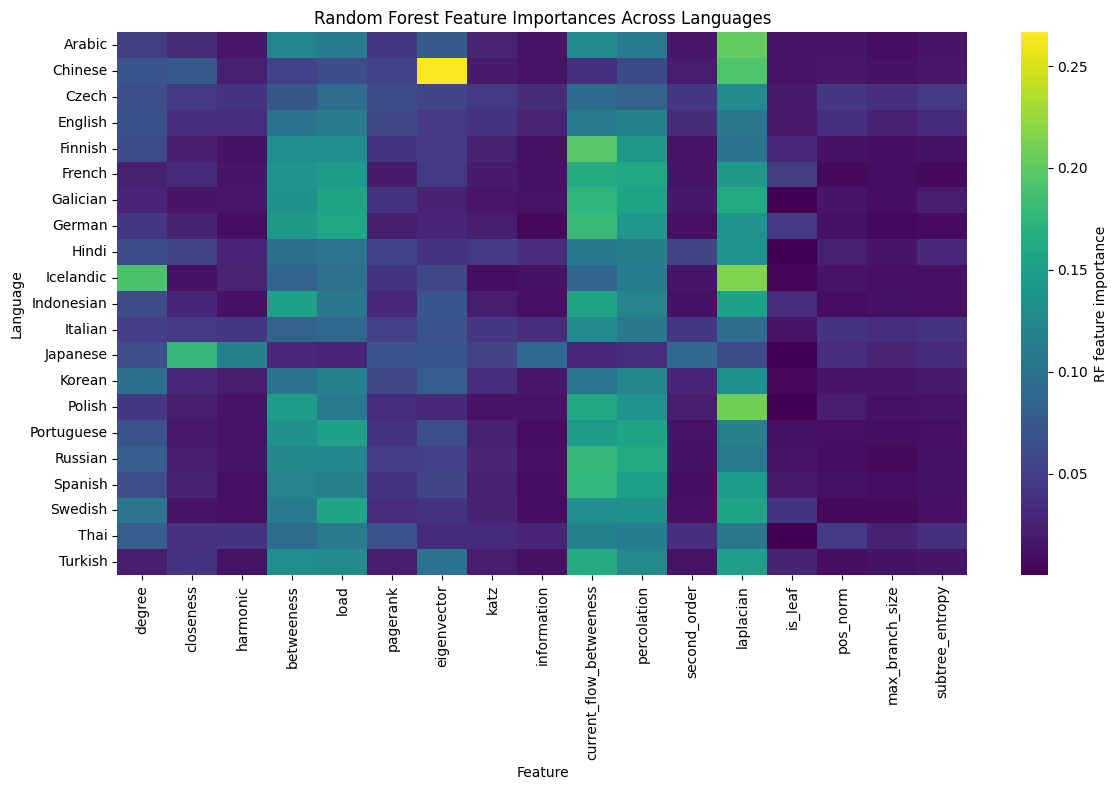

In [119]:
# heatmap of feature importances
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(
    imp_mat.astype(float),
    cmap='viridis',
    cbar_kws={'label': 'RF feature importance'},
    yticklabels=True
)
plt.title('Random Forest Feature Importances Across Languages')
plt.ylabel('Language')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

As we can see, feature importance patterns vary widely by language. Some centralities matter more in Germanic languages, subtree features in Slavic, etc, but we can't separate it either to language families properly based on this. Overall, no universal feature clearly separates roots across all languages, but there are features that contribute greatly to all, like laplacian and current_flow_betweeness. However, this is not enough for a universal classifier to do better on this data (we also tried it).